In this notebook we demonstrate the application of a Fourier filter during map-making. The purpose of the filter is to remove all modes in the time-ordered data that are not oscillating with a $4 f_{\mathrm{HWP}}$ frequency. The frequency $f_{\mathrm{HWP}}$ is related to the angular frequency $\omega_{\mathrm{HWP}} =  2 \pi f_{\mathrm{HWP}}$ of a spinning half-wave plate. If the instrument would continuously point towards a point on the sky, an ideal spinning HWP would exactly modulate the time-ordered signal from the $Q$ and $U$ sky signal at $4 f_{\mathrm{HWP}}$. After applying the filter, the unpolarized sky signal and signal due to certain HWP non-idealities would be gone from the data because both of these components oscillate at different frequencies. The $Q$ and $U$ sky signal would remain unaltered.

One caveat to the above is that the instrument itself also scans over the sky. Therefore, the low-$\ell$ polarized signal will not be modulated at $4 f_{\mathrm{HWP}}$ and will also be filtered away. The cutoff in $\ell$ clearly depends on the scan speed and $f_{\mathrm{HWP}}$ of the instrument. In general, there will be a transfer function. As a reference, the ABS instrument scans at 0.3-0.7 $\deg\, s^{-1}$ and has $f_{\mathrm{HWP}} = 2.5 \ \mathrm{Hz}$.

It should be noted that our implemention of the Fourier filter is different than the one described for ABS in Kusaka et al. (1310.3711). However, in the simple noiseless case that we consider here, the two approaches should yield highly comparable results.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import healpy as hp
from beamconv import Beam, ScanStrategy, tools

In [2]:
# Start by defining a beam and sky alms
lmax = 800
beam = Beam(btype='Gaussian', fwhm=32.2, lmax=lmax)

fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'
cl_arr = np.loadtxt(fname, unpack=True)
ells = cl_arr[0]
cls = cl_arr[1:]
np.random.seed(10)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True)

In [3]:
# Create a ScanStrategy instance and add our beam to its focal plane.
S = ScanStrategy(1000, sample_rate=100, location='spole') 
S.add_to_focal_plane(beam, combine=False)

In [4]:
# Add a spinning HWP to the instrument
S.set_hwp_mod(mode='continuous', freq=2.5)
# Scan the sky with our instrument, solve for I, Q, and U, and store for later comparisons.
S.allocate_maps(nside=512)
S.scan_instrument_mpi(alm, save_tod=True, save_point=True, binning=True, scan_speed=0.5, interp=True, nside_spin=512)
maps, cond = S.solve_for_map(fill=np.nan)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-100000


/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


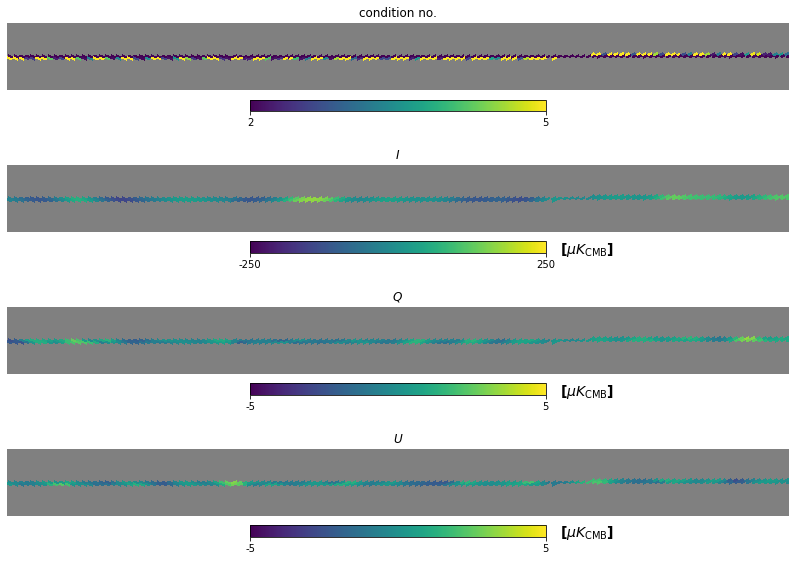

In [5]:
# Plot the scan.
cart_opts = dict(lonra=[-25, 10], latra=[-59, -56], hold=True)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(14, 10))
plt.axes(axs[0])
hp.cartview(cond, min=2, max=5, title='condition no.', **cart_opts)
plt.axes(axs[1])
hp.cartview(maps[0], min=-250, max=250, title=r'$I$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[2])
hp.cartview(maps[1], min=-5, max=5, title=r'$Q$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[3])
hp.cartview(maps[2], min=-5, max=5, title=r'$U$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)

In [6]:
tod = S.data(S.chunks[0], beam=beam, data_type='tod')
# Make a copy for later comparisons.
tod_unfilt = tod.copy()

Text(0, 0.5, 'signal [$\\mathrm{\\mu K_{CMB}}$]')

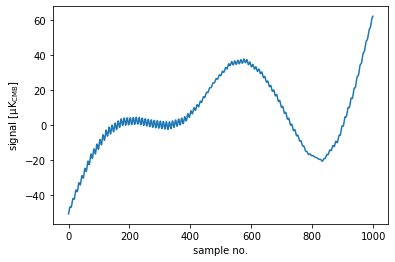

In [7]:
# Take a look a the resulting tod, the large scale fluctuations are mostly the I signal,
# the oscillating part is most of the polarized signal.
plt.plot(tod_unfilt[:1000])
plt.xlabel('sample no.')
plt.ylabel(r'signal [$\mathrm{\mu K_{CMB}}$]')

Text(0, 0.5, 'power [$\\mathrm{\\mu K_{CMB}^2 Hz^{-1}}$]')

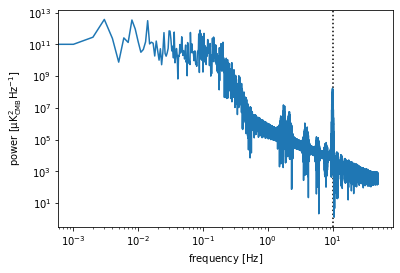

In [8]:
# Lets plot the power spectrum of the TOD. Note the peak at 4 * fHWP, this is where most of the polarized signal is.
hwp_freq = S.hwp_dict['freq']
fd = np.fft.rfft(tod_unfilt)
freqs = np.fft.rfftfreq(tod.size, d=1/S.fsamp)
plt.axvline(4 * hwp_freq, color='black', linestyle=':')
plt.plot(freqs, np.abs(fd) ** 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency [$\mathrm{Hz}$]')
plt.ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')

Text(0, 0.5, 'power [$\\mathrm{\\mu K_{CMB}^2 Hz^{-1}}$]')

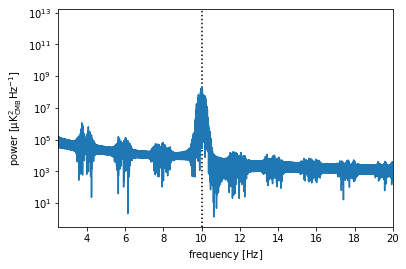

In [9]:
# Lets zoom in a little around the peak.
plt.axvline(4 * hwp_freq, color='black', linestyle=':')
plt.plot(freqs, np.abs(fd) ** 2)
plt.yscale('log')
plt.xlim([hwp_freq, 8*hwp_freq])
plt.xlabel('frequency [$\mathrm{Hz}$]')
plt.ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')

Text(0.5, 1.0, 'Tukey Window example')

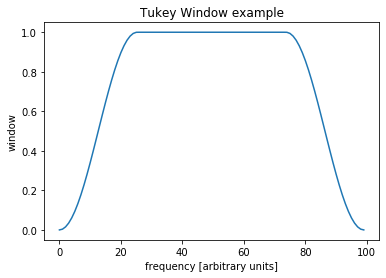

In [10]:
# Lets apply a fourier filter around this peak at 4 x fHWP
# The filter I have implemented is a simple Tukey Window.
plt.plot(tools.tukey_window(100))
plt.xlabel('frequency [arbitrary units]')
plt.ylabel('window')
plt.title('Tukey Window example')

In [11]:
# Lets apply the filter
tools.filter_tod_hwp(tod, S.fsamp, hwp_freq)

Text(0, 0.5, 'power [$\\mathrm{\\mu K_{CMB}^2 Hz^{-1}}$]')

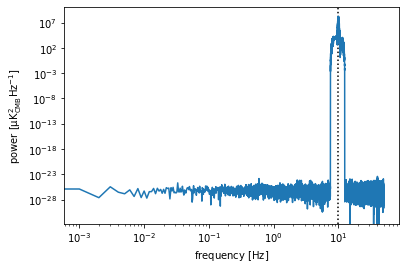

In [12]:
# We plot the power spectrum again.
fd_filt = np.fft.rfft(tod)
plt.axvline(4 * hwp_freq, color='black', linestyle=':')
plt.plot(freqs, np.abs(fd_filt) ** 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency [$\mathrm{Hz}$]')
plt.ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')

(2.5, 20.0)

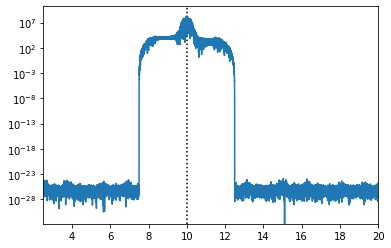

In [13]:
# Zoom in again.
plt.axvline(4 * hwp_freq, color='black', linestyle=':')
plt.plot(freqs, np.abs(fd_filt) ** 2)
plt.yscale('log')
plt.xlim([hwp_freq, 8*hwp_freq])

Text(0, 0.5, 'signal [$\\mathrm{\\mu K_{CMB}}$]')

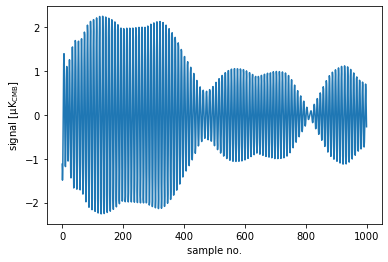

In [14]:
# The filtered TOD only has the 4*fHWP modulated part. 
# The different wave packets correspond to different pixels in the Q and U maps
# Note that there is some ringing at the edges of the tod, seems pretty minor.
plt.plot(tod[:1000])
plt.xlabel('sample no.')
plt.ylabel(r'signal [$\mathrm{\mu K_{CMB}}$]')

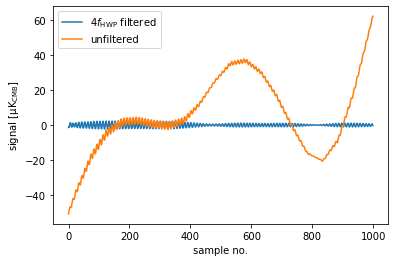

In [15]:
# Plotted together with unfiltered tod
plt.plot(tod[:1000], label=r'$4 f_{\mathrm{HWP}}$ filtered')
plt.plot(tod_unfilt[:1000], label='unfiltered')
plt.xlabel('sample no.')
plt.ylabel(r'signal [$\mathrm{\mu K_{CMB}}$]')
plt.legend()

In [16]:
# Now, lets compare maps. 
# Note, the Fourier filter is implemented in scan_instrument_mpi,
# so we can simply add `filter_4fhwp=False` to the call
S.reset_hwp_mod()
S.allocate_maps(nside=512)
S.scan_instrument_mpi(alm, save_tod=True, save_point=True, binning=True, scan_speed=0.5, 
                      interp=True, reuse_spinmaps=True, filter_4fhwp=True)
maps_filtered, cond_filtered = S.solve_for_map(fill=np.nan)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-100000


/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


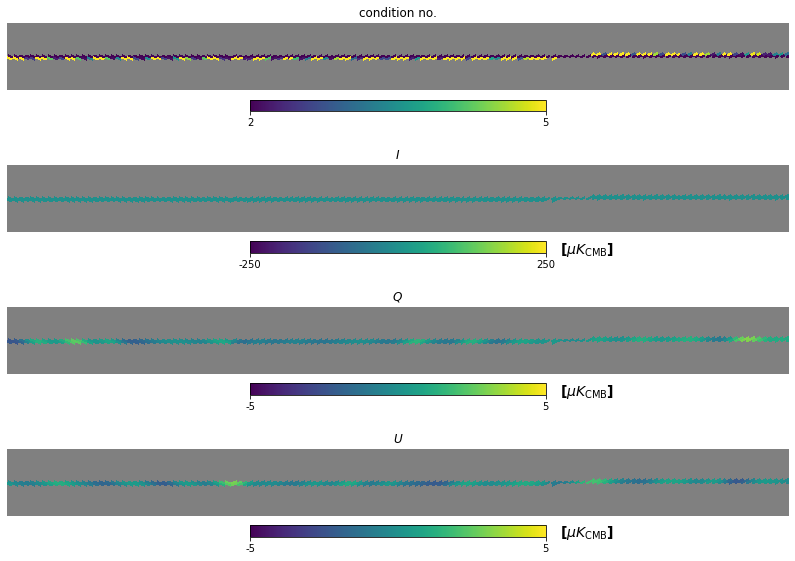

In [17]:
# Plot the filtered scan. As expected, we have removed all I signal, we seem to retain the Q and U signal.
# Condition number should be the same.
cart_opts = dict(lonra=[-25, 10], latra=[-59, -56], hold=True)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(14, 10))
plt.axes(axs[0])
hp.cartview(cond_filtered, min=2, max=5, title='condition no.', **cart_opts)
plt.axes(axs[1])
hp.cartview(maps_filtered[0], min=-250, max=250, title=r'$I$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[2])
hp.cartview(maps_filtered[1], min=-5, max=5, title=r'$Q$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[3])
hp.cartview(maps_filtered[2], min=-5, max=5, title=r'$U$', unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)

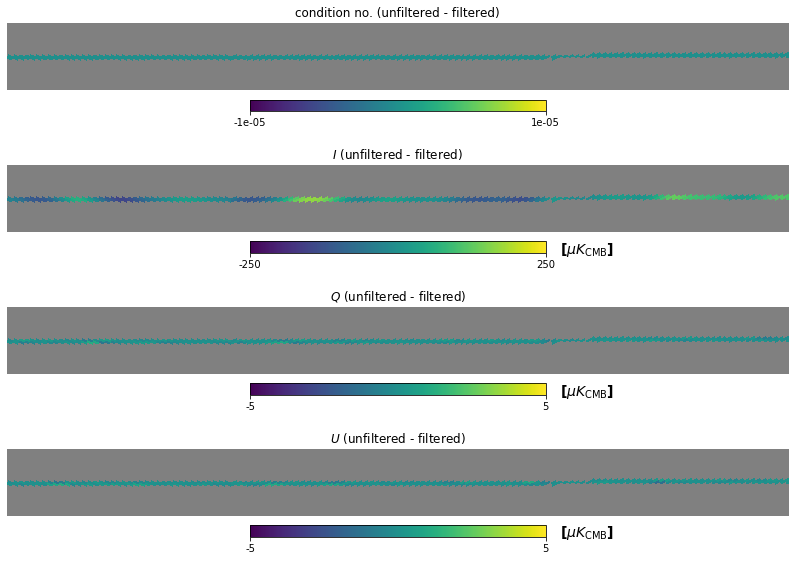

In [18]:
# Plot difference maps. 
# We see that condition number maps are identical, as they should as we haven't touched the pointing.
# We also see that some large-scale polarization modes are filtered away.
cart_opts = dict(lonra=[-25, 10], latra=[-59, -56], hold=True)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(14, 10))
plt.axes(axs[0])
hp.cartview(cond - cond_filtered, min=-1e-5, max=1e-5, title='condition no. (unfiltered - filtered)', **cart_opts)
plt.axes(axs[1])
hp.cartview(maps[0] - maps_filtered[0], min=-250, max=250, title=r'$I$ (unfiltered - filtered)',
            unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[2])
hp.cartview(maps[1] - maps_filtered[1], min=-5, max=5, title=r'$Q$ (unfiltered - filtered)',
                unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[3])
hp.cartview(maps[2] - maps_filtered[2], min=-5, max=5, title=r'$U$ (unfiltered - filtered)',
                unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)

### CAVEAT: pixelization ###
Note that in the above, we have used the `interp=True` option. This option interpolates pixel values while scanning maps. This option is not standard because it significantly slows down the overall evaluation of the algorithm. The interpolation is used because of the Fourier transforms used for the filter. Without interpolation, the TOD are not band-limited; there are sharp jumps in the data between pixels. As a result, the filtering is less accurate without interpolation. Note that an alternative to the interpolation is inceasing the `nside` parameter of the `spinmaps` from 512 to e.g. 2048. The downside of this option the associated increase in memory consumption, as every rank now needs to hold several large maps in its memory.

In [19]:
# Save filtered tod before we overwrite it again
tod_filtered = tod

In [20]:
# Now, lets scan without interpolation while keeping the spinmaps at nside 512.
S.reset_hwp_mod()
S.allocate_maps(nside=512)
S.scan_instrument_mpi(alm, save_tod=True, save_point=True, binning=True, scan_speed=0.5, 
                      interp=False, reuse_spinmaps=True, filter_4fhwp=True)
maps_filtered_pixel, cond_filtered_pixel = S.solve_for_map(fill=np.nan)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-100000


/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


In [21]:
tod_pixel = S.data(S.chunks[0], beam=beam, data_type='tod').copy()

Text(0, 0.5, 'power [$\\mathrm{\\mu K_{CMB}^2 Hz^{-1}}$]')

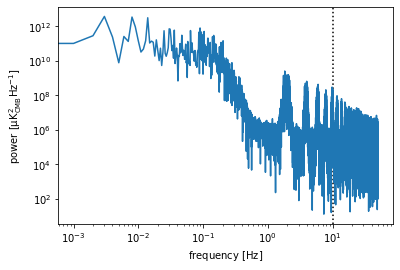

In [22]:
# We clearly see the effects of the pixelization in the power spectrum.
fd = np.fft.rfft(tod_pixel)
plt.axvline(4 * hwp_freq, color='black', linestyle=':')
plt.plot(freqs, np.abs(fd) ** 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency [$\mathrm{Hz}$]')
plt.ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')

In [23]:
tools.filter_tod_hwp(tod_pixel, S.fsamp, hwp_freq)

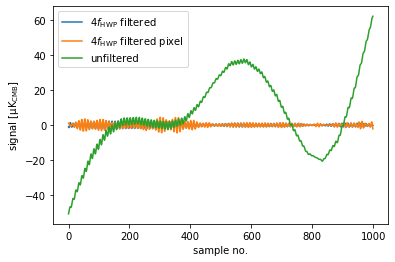

In [24]:
# Compare the 3 types of TOD we now have.
plt.plot(tod_filtered[:1000], label=r'$4 f_{\mathrm{HWP}}$ filtered')
plt.plot(tod_pixel[:1000], label=r'$4 f_{\mathrm{HWP}}$ filtered pixel')
plt.plot(tod_unfilt[:1000], label='unfiltered')
plt.xlabel('sample no.')
plt.ylabel(r'signal [$\mathrm{\mu K_{CMB}}$]')
plt.legend()

Text(0.5, 1.0, 'filtered - filtered_pixel')

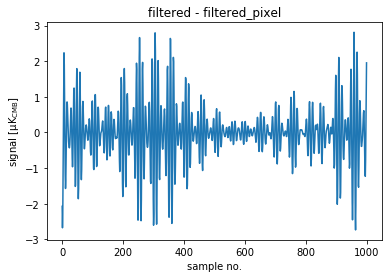

In [25]:
# Plot difference between with interpolated filtered TOD.
plt.plot(tod_filtered[:1000] - tod_pixel[:1000])
plt.xlabel('sample no.')
plt.ylabel(r'signal [$\mathrm{\mu K_{CMB}}$]')
plt.title(r'filtered - filtered_pixel')

/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/Users/adri/.pyenv/versions/3.8.0/envs/beamconv/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


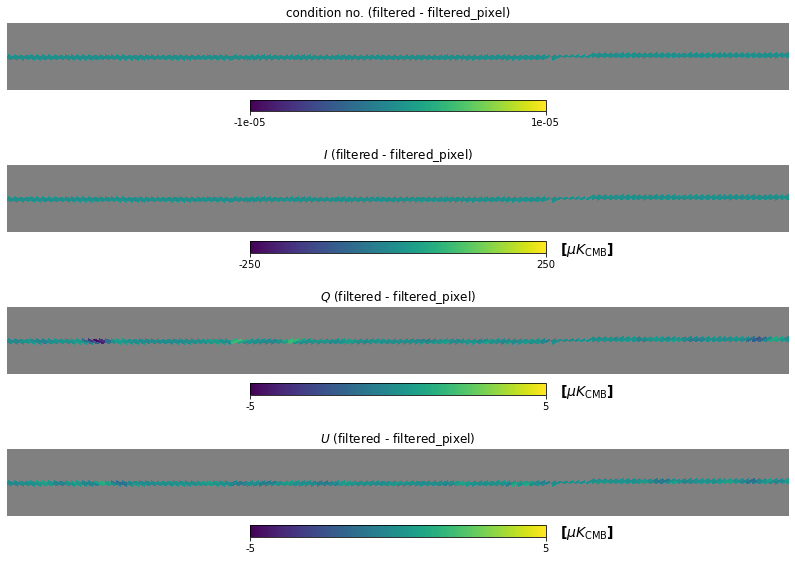

In [26]:
# Plot difference maps between interpolated and not interpolated. 
# We see quite a large difference in Q and U. Too large probably.
cart_opts = dict(lonra=[-25, 10], latra=[-59, -56], hold=True)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(14, 10))
plt.axes(axs[0])
hp.cartview(cond_filtered - cond_filtered_pixel, min=-1e-5, max=1e-5,
            title='condition no. (filtered - filtered_pixel)', **cart_opts)
plt.axes(axs[1])
hp.cartview(maps_filtered[0] - maps_filtered_pixel[0], min=-250, max=250, title=r'$I$ (filtered - filtered_pixel)',
            unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[2])
hp.cartview(maps_filtered[1] - maps_filtered_pixel[1], min=-5, max=5, title=r'$Q$ (filtered - filtered_pixel)',
                unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)
plt.axes(axs[3])
hp.cartview(maps_filtered[2] - maps_filtered_pixel[2], min=-5, max=5, title=r'$U$ (filtered - filtered_pixel)',
                unit=r'[$\mu K_{\mathrm{CMB}}$]', **cart_opts)